In [1]:
import pandas as pd
import numpy as np
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import cross_val_score
import re
import codecs
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [2]:
smaller_data=pd.read_csv("../data/50k_data_crunchbase.csv")

In [3]:
smaller_data

,_id,company_description,company_industry,company_sector
0,5ba5edf17c86660ac1277389,"Founded in 2005 by Art Howe, CIU Networks INC ...",Information Technology and Services,Technology
1,5ba8ab4a7c866639437d4223,Pulling your hair out over mindless call after...,Information Technology and Services,Technology
2,5ba5ef497c86660ac12a31f6,Creative Facility Design can recommend alterna...,Information Technology and Services,Technology
3,5ba70d9540437e5d2c69af56,PVM Innvensys Pvt Ltd is an information techno...,Information Technology and Services,Technology
4,5ba5f2e77c86660ac13009ea,Eleview International Inc is an information te...,Information Technology and Services,Technology
...,...,...,...,...
50069,5c3b0525d55ae49f1b7d4047,Office of Rep. James P. McGovern is a represen...,Legislative Office,Professional Services
50070,5c3b06cdd55ae49f1b7fb887,The Joint Economic Committee (JEC) was created...,Legislative Office,Professional Services
50071,5c3b0402d55ae49f1b7bb343,The International Court of Justice (ICJ) is th...,Judiciary,Professional Services
50072,5c3b06d7d55ae49f1b7fc803,Middle district of florida web site provides i...,Judiciary,Professional Services


In [2]:
df=smaller_data

In [3]:
from io import StringIO
col = ['company_industry', 'company_description']
df = df[col]
df = df[pd.notnull(df['company_description'])]
df.columns = ['company_industry', 'company_description']
df['category_id'] = df['company_industry'].factorize()[0]
category_id_df = df[['company_industry', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'company_industry']].values)
df.head()

,company_industry,company_description,category_id
0,Information Technology and Services,"Founded in 2005 by Art Howe, CIU Networks INC ...",0
1,Information Technology and Services,Pulling your hair out over mindless call after...,0
2,Information Technology and Services,Creative Facility Design can recommend alterna...,0
3,Information Technology and Services,PVM Innvensys Pvt Ltd is an information techno...,0
4,Information Technology and Services,Eleview International Inc is an information te...,0


In [4]:
df['category_id'].value_counts()

0      6098
20     4145
5      3159
8      2880
50     1943
       ... 
88        6
144       5
136       4
146       3
145       2
Name: category_id, Length: 147, dtype: int64

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', max_features=5000,
                        encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.company_description).toarray()
labels = df.category_id
features.shape

(50074, 5000)

In [6]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Accounting':
  . Most correlated unigrams:
. tax
. accounting
  . Most correlated bigrams:
. advisory services
. business consulting
# 'Airlines/Aviation':
  . Most correlated unigrams:
. airlines
. aviation
  . Most correlated bigrams:
. customers world
. low cost
# 'Alternative Dispute Resolution':
  . Most correlated unigrams:
. alternative
. resolution
  . Most correlated bigrams:
. non profit
. profit organization
# 'Alternative Medicine':
  . Most correlated unigrams:
. medicine
. cannabis
  . Most correlated bigrams:
. quality management
. sq ft
# 'Animation':
  . Most correlated unigrams:
. productions
. animation
  . Most correlated bigrams:
. video production
. virtual reality
# 'Apparel & Fashion':
  . Most correlated unigrams:
. fashion
. apparel
  . Most correlated bigrams:
. shopping experience
. men women
# 'Architecture & Planning':
  . Most correlated unigrams:
. architectural
. architecture
  . Most correlated bigrams:
. design firm
. interior design
# 'Arts and Cr

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['company_description'], df['company_industry'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

/home/slintel/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/slintel/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/slintel/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/slintel/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/slintel/my_env

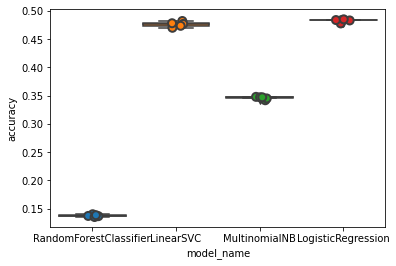

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
     MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

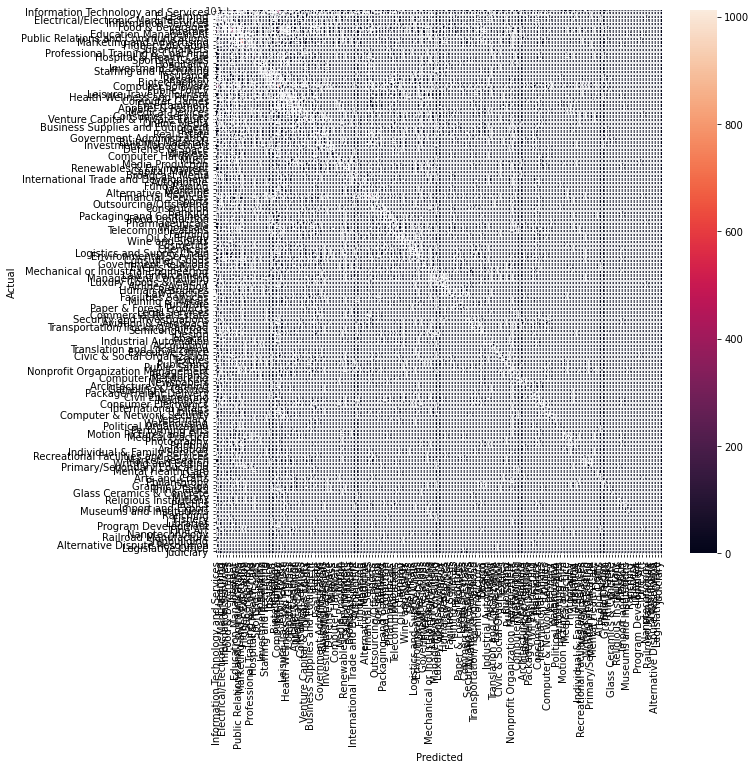

In [11]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.company_industry.values, yticklabels=category_id_df.company_industry.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['company_industry'].unique()))

                                      precision    recall  f1-score   support

 Information Technology and Services       0.42      0.50      0.46      2008
                          E-Learning       0.41      0.51      0.45       123
 Electrical/Electronic Manufacturing       0.45      0.45      0.45       222
                Information Services       0.09      0.01      0.02        73
                    Food & Beverages       0.42      0.46      0.44       177
                            Internet       0.31      0.34      0.32      1077
                Education Management       0.45      0.35      0.39       208
 Public Relations and Communications       0.70      0.65      0.68        81
           Marketing and Advertising       0.54      0.67      0.60       916
                    Higher Education       0.56      0.68      0.61       161
                        Supermarkets       0.00      0.00      0.00         4
    Professional Training & Coaching       0.43      0.30      

/home/slintel/my_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slintel/my_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/slintel/my_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
